In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

mydb=mysql.connector.connect(host="localhost",user="root",passwd="#Kh717299",database="ecommerce")

cur=mydb.cursor()


# List all unique cities where customers are located

In [3]:
query="""select distinct upper(customer_city) from customers"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Customer_city"])
df

,Customer_city
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# Count the number of orders placed in 2018

In [23]:
query="""select count(order_id) from orders where(order_purchase_timestamp)=2018"""

cur.execute(query)

data=cur.fetchall()

"Total orders placed in 2018 are", data[0][0]

('Total orders placed in 2018 are', 54011)

# Find the total sale per category

In [35]:
query="""select upper(p.product_category) AS category,                  #products table alias as p
round(sum(pa.payment_value),2) AS sales                                 #payments table alias as pa
from products p join order_items o                                      #order_items table alias as o
on p.product_id= o.product_id 
join payments pa
on pa.order_id=o.order_id
group by category"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,FASHION BAGS AND ACCESSORIES,436316.56
4,BED TABLE BATH,3425107.34
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# Count the number of customers from each state

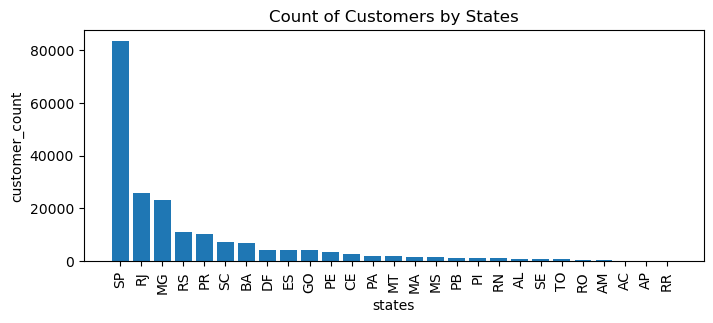

In [4]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the percentage of orders that were paid in installments.

In [4]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Calculate the number of orders per month in 2018.

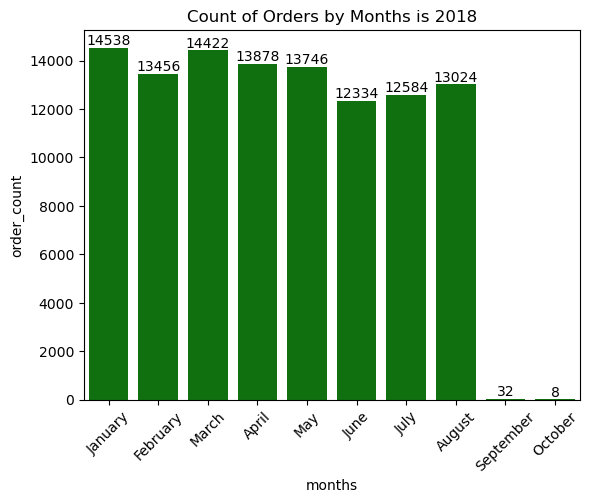

In [6]:
query = """ select monthname(order_purchase_timestamp) as months, count(order_id) as order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [8]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,picarra,8.00
7,morro de sao paulo,8.00
8,teixeira soares,8.00
9,curralinho,8.00


# Calculate the percentage of total revenue contributed by each product category.

In [7]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86


# Calculate the total revenue generated by each seller, and rank them by revenue.

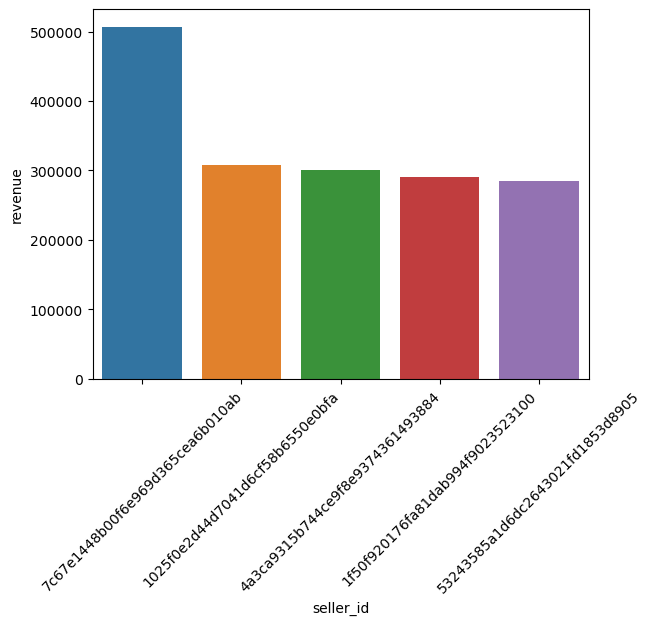

In [9]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 45)
plt.show()


# Identify the top 3 customers who spent the most money in each year.

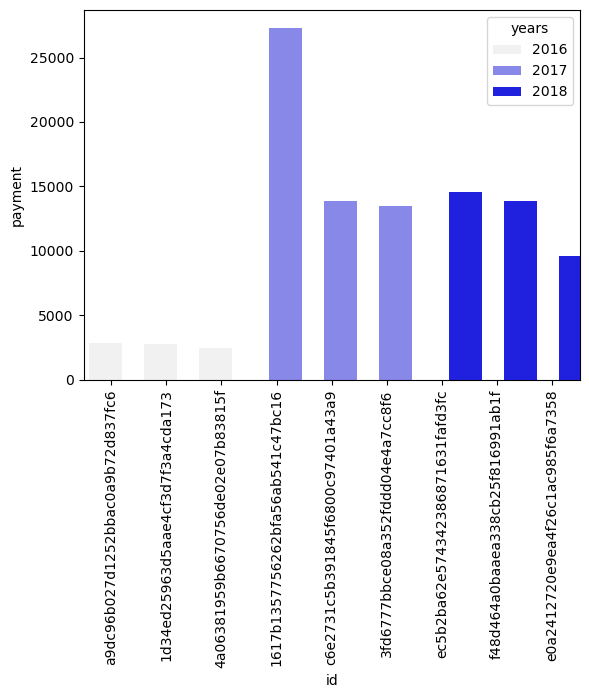

<Figure size 800x300 with 0 Axes>

In [34]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years",color = 'blue')
for bar in plt.gca().patches:
    bar.set_width(0.6)
plt.xticks(rotation = 90)
plt.figure(figsize = (8,3))
plt.show()